<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/v24_3_Monthly_Carbon_Emission_in_ISONE_CAISO_NWISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monthly Carbon Emission in ISONE CAISO NWISO

<a id="section-one"></a>
# 1.DataSet Description

Dataset is 1 fuel mix  in year 2020 from  EIA for 

- [1] CA ISO ( California)
- [2] ISO New England 
- [3] NorthWest ISO 

<a id="section-two"></a>
# 2.Import & Preprocessing

Let's have a first look at the data. For the sake of simplicity we are only looking at data of plant 1 (power generation and weather). Data of power plant 2 can then be explored in a similar manner.

In [40]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [41]:
from google.colab import drive
drive.mount('/content/drive')
import glob
from zipfile import ZipFile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## column_list_Mwh and color list

In [42]:
column_list_Mwh= ['Wind Generation (MWh)','Solar Generation (MWh)', 'Hydro Generation (MWh)','Other Generation (MWh)', 'Petroleum Generation (MWh)','Natural gas Generation (MWh)', 'Coal Generation (MWh)','Nuclear Generation (MWh)','Battery Generation (MWh)','Imports Generation (MWh)']
column_list = ("Wind",    "Solar",  "Hydro",  "Other",    "Petroleum",  "Natural gas", "Coal",     "Nuclear",  "Battery", "Imports")
# color_list  = ["skyblue", "gold",   "teal",   "deeppink", "red",  "brown",      "darkgrey", "green",    "aqua"  , "grey"]

## column_list_percent

In [43]:
column_list_percent = [ sub.replace("(MWh)","(%)") for sub in column_list_Mwh]
column_list_percent

['Wind Generation (%)',
 'Solar Generation (%)',
 'Hydro Generation (%)',
 'Other Generation (%)',
 'Petroleum Generation (%)',
 'Natural gas Generation (%)',
 'Coal Generation (%)',
 'Nuclear Generation (%)',
 'Battery Generation (%)',
 'Imports Generation (%)']

In [44]:
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]
column_list_carbon

['carbon_Wind(kgeCO2)',
 'carbon_Solar(kgeCO2)',
 'carbon_Hydro(kgeCO2)',
 'carbon_Other(kgeCO2)',
 'carbon_Petroleum(kgeCO2)',
 'carbon_Natural gas(kgeCO2)',
 'carbon_Coal(kgeCO2)',
 'carbon_Nuclear(kgeCO2)',
 'carbon_Battery(kgeCO2)',
 'carbon_Imports(kgeCO2)']

In [45]:
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Raw Industrial Energy consumption and carbon footprint 

In [46]:
column_list_power = [ sub + "(W)" for sub in column_list]
column_list_power

['Wind(W)',
 'Solar(W)',
 'Hydro(W)',
 'Other(W)',
 'Petroleum(W)',
 'Natural gas(W)',
 'Coal(W)',
 'Nuclear(W)',
 'Battery(W)',
 'Imports(W)']

In [47]:
# Medium Industry 2009 ( 354 kW - 568 kW )
Region="MediumIndustry2009"
dfindus = pd.read_csv('/content/drive/MyDrive/power/dataset/industrial_energy_comsumption/indust data P_2009.csv')
dfindus.drop(["Unnamed: 4"], axis=1, inplace=True)  
dfindus.drop(["Unnamed: 5"], axis=1, inplace=True)  
dfindus.drop(["kvarh d"], axis=1, inplace=True)  
# print(dfindus.columns)

startdate = datetime.date(2009,1, 1)
enddate = datetime.date(2009, 12, 31)

# dfindus.head()

In [48]:
#nan and not null
dfindus = dfindus[dfindus.Date.notnull()]

dfindus["Date"] = pd.to_datetime(dfindus["Date"],errors='coerce').dt.date #  date
dfindus["Time"] = pd.to_datetime(dfindus["Time"],errors='coerce').dt.time #  time

#timesatmp format
dfindus['Timestamp'] = pd.to_datetime(dfindus['Date'].apply(str) +' '+ dfindus['Time'].apply(str), format = '%Y-%m-%d %H:%M:%S')

#Rename Columns
dfindus =   dfindus.rename(columns={"Date": "DATE",
                            "Time" : "TIME",
                            "kWh d": "energy(kWh)"
                          })
# Remove duplicates 
dfindus = dfindus[dfindus['DATE'].between(startdate, enddate, inclusive=True)]
dfindus = dfindus.sort_values(by=['Timestamp'],ascending=True)
dfindus = dfindus.drop_duplicates(subset='Timestamp', keep="first")

#  Fill undefined and nan
dfindus = dfindus.replace('undefined', 0)
dfindus = dfindus.fillna(0)
dfindus = dfindus.replace(np.nan, 0)
# dfindus = dfindus.set_index('TIME')
# dfindus.index = dfindus['TIME']

#  Power = Energy / Time
dfindus["power(kW)"] = dfindus["energy(kWh)"]* 60/15
dfindus["power(W)"] = dfindus["power(kW)"] * 1000

In [49]:
dfindus_hourly = dfindus.resample('H',on='Timestamp').agg({ 
                                        'power(W)':'mean',
                                        'Timestamp':'first',
                                        'DATE':'unique'})
dfindus_hourly = dfindus_hourly.reset_index(drop=True)

In [50]:
# df_calculate_fuelmixbypercent(dfindus_hourly, dfwhole)

In [51]:
# df_calculate_carbon2(dfindus_hourly, column_list_power)

In [52]:
!pip install carbonfootprint==1.2.3

In [53]:
from carbonfootprint.carbon import Carbon
from carbonfootprint.fuelmix import Fuelmix

In [54]:
region ="north_west"
furlpercent_obj = Fuelmix("north_west")
dfindus_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(dfindus_hourly)

carbonemissio_pbj = Carbon()
dfindus_hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(dfindus_hourly_fuelmix)

   power(W)           Timestamp          DATE
0  312480.0 2009-01-01 00:00:00  [2009-01-01]
1  311760.0 2009-01-01 01:00:00  [2009-01-01]
2  311760.0 2009-01-01 02:00:00  [2009-01-01]
3  312480.0 2009-01-01 03:00:00  [2009-01-01]
4  311040.0 2009-01-01 04:00:00  [2009-01-01]
utility_fuelmix filenames /usr/local/lib/python3.7/dist-packages/carbonfootprint/dataset/north_west2020/*.csv
  Region Code  ... Imports Generation (%)
0          NW  ...                    0.0
1          NW  ...                    0.0
2          NW  ...                    0.0
3          NW  ...                    0.0
4          NW  ...                    0.0

[5 rows x 24 columns]
-------------dfindus_hourly_fuelmix------------------
   power(W)           Timestamp          DATE  ...  Battery(W)  Imports(W)  total(W)
0  312480.0 2009-01-01 00:00:00  [2009-01-01]  ...         0.0         0.0  312480.0
1  311760.0 2009-01-01 01:00:00  [2009-01-01]  ...         0.0         0.0  311760.0
2  311760.0 2009-01-01 02:00:0

In [55]:
dfindus_hourly["Timestamp"].dt.month.unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

## graph for Carbon produced from raw 

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

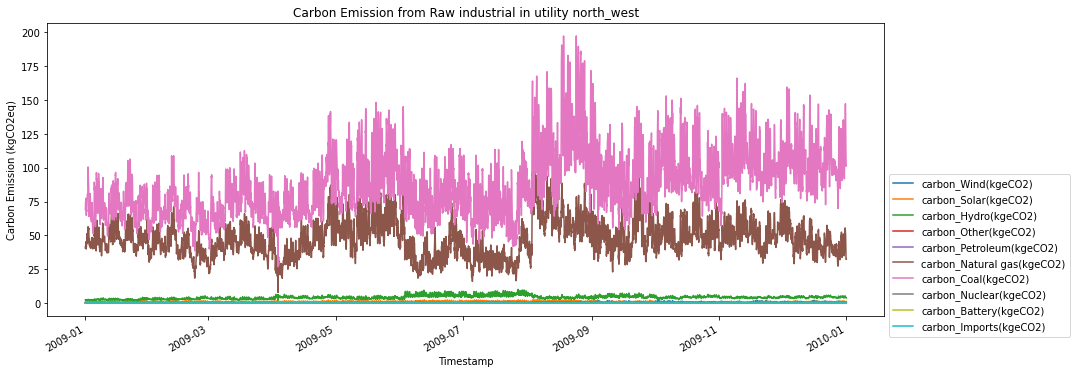

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfindus_hourly_fuelmix_carbon.plot( 
    x = "Timestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from Raw industrial in utility "+ region ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

# Industrial Energy consumption and carbon footprint after Behind-the-meter storage

In [57]:
industry = "indust1_seattle_pricing"
# industry = "indust1_hge_pricing"

name = "load_aft_batt_on_grid.txt_11310000.0_hwb"

print( industry + " " + name + " "+ region)
dfbattery0 = pd.read_csv('/content/drive/MyDrive/power/dataset/'+industry+'/'+name ,header=None)
# dfbattery0['DATE'] = pd.to_datetime(dfbattery[0],format = '%m_%d_%Y').dt.date

dfbattery0.head()

indust1_seattle_pricing load_aft_batt_on_grid.txt_11310000.0_hwb north_west


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
0,01_01_2009,313920.0,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,...,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714,319093.034714
1,01_02_2009,319680.0,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,...,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,379725.194805,374400.000000,374400.000000,354240.000000,351360.000000,348480.000000,342720.000000,342720.000000,336960.000000,334080.000000,334080.000000,334080.000000,339840.000000,334080.000000,328320.000000,325440.000000,322560.000000,325440.000000,325440.000000,325440.000000,322560.000000,325440.000000,322560.000000,322560.000000,325440.000000,319680.000000,316800.000000,316800.000000,316800.000000,311040.000000,313920.000000,302400.000000
2,01_03_2009,311040.0,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,316198.834951,...,285120.000000,285120.000000,288000.000000,288000.000000,288000.000000,282240.000000,285120.000000,285120.000000,279360.000000,288000.000000,288000.000000,296640.000000,302400.000000,299520.000000,302400.000000,302400.000000,299520.000000,302400.000000,299520.000000,299520.000000,302400.000000,302400.000000,299520.000000,302400.000000,299520.000000,305280.000000,299520.000000,302400.000000,302400.000000,302400.000000,302400.000000,308160.000000,302400.000000,302400.000000,302400.000000,305280.000000,299520.000000,299520.000000,302400.000000,302400.000000
3,01_04_2009,296640.0,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,300464.822134,299520.0000

In [69]:
def df_calculate_btmcarbon(dfbattery0): 

    dfbattery = pd.DataFrame(columns = ['power(W)','DATE', 'TIME'])
    dfbattery.head()

    for i, row in dfbattery0.iterrows():

      r1 = pd.DataFrame(columns = ['power(W)','DATE', 'TIME'])
      r1["power(W)"] = row
      date = pd.to_datetime(row.iloc[0],format = '%m_%d_%Y')
      r1 = r1[1:97]

      r1['power(W)'] = pd.to_numeric(r1['power(W)'])
      r1["DATE"] = date
      # print(date)

      # artifically add 15 mins timestamp  
      index = pd.date_range(date, periods=96, freq='15T')
      series = pd.Series(range(0,96,1), index=index, name='Times')
      series = pd.to_datetime(series.index)
      r1["TIME"] = series

      dfbattery = dfbattery.append(r1)

    # dfbattery.reset_index()
    dfbattery = dfbattery.resample('H',on='TIME').agg({
                                            'power(W)':'mean', 
                                            'TIME':'first',
                                            'DATE':'first'})
    dfbattery = dfbattery.reset_index(drop=True)

    # Fill up missing
    # dfbattery = dfbattery.interpolate(method ='pad', limit_direction ='forward')
    return dfbattery

### Regex match for battery capacity in filename

        power(W)                TIME       DATE
0  317799.776036 2009-01-01 00:00:00 2009-01-01
1  319093.034714 2009-01-01 01:00:00 2009-01-01
2  319093.034714 2009-01-01 02:00:00 2009-01-01
3  319093.034714 2009-01-01 03:00:00 2009-01-01
4  319093.034714 2009-01-01 04:00:00 2009-01-01
utility_fuelmix filenames /usr/local/lib/python3.7/dist-packages/carbonfootprint/dataset/north_west2020/*.csv
  Region Code  ... Imports Generation (%)
0          NW  ...                    0.0
1          NW  ...                    0.0
2          NW  ...                    0.0
3          NW  ...                    0.0
4          NW  ...                    0.0

[5 rows x 24 columns]
        power(W)                TIME       DATE
0  317799.776036 2009-01-01 00:00:00 2009-01-01
1  319093.034714 2009-01-01 01:00:00 2009-01-01
2  319093.034714 2009-01-01 02:00:00 2009-01-01
3  319093.034714 2009-01-01 03:00:00 2009-01-01
4  319093.034714 2009-01-01 04:00:00 2009-01-01
utility_fuelmix filenames /usr/local/li

,Timestamp,_1017900,_10179000,_113100,_1131000,_11310000,_1244100,_1357200,_1470300,_1583400,_1696500,_1809600,_1922700,_2035800,_2148900,_226200,_2262000,_2827500,_339300,_3393000,_452400,_4524000,_565500,_5655000,_678600,_6786000,_7916999,_791700,_904800,_9048000
0,2009-01-01 00:00:00,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437,1.702437
1,2009-01-01 01:00:00,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141
2,2009-01-01 02:00:00,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141,2.352141
3,2009-01-01 03:00:00,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307,2.116307
4,2009-01-01 04:00:00,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067,2.589067


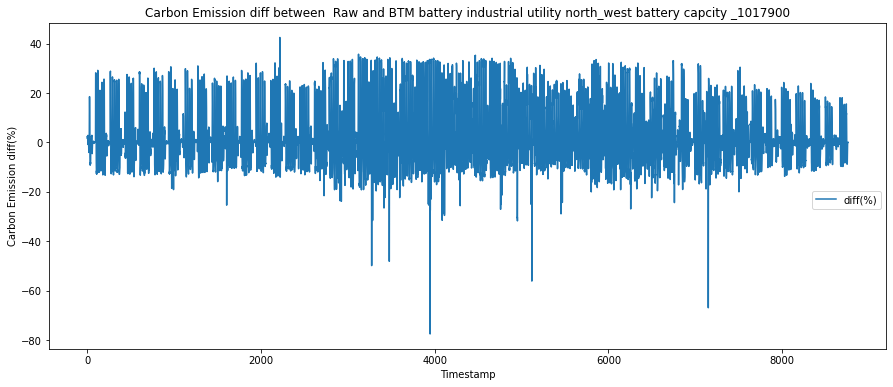

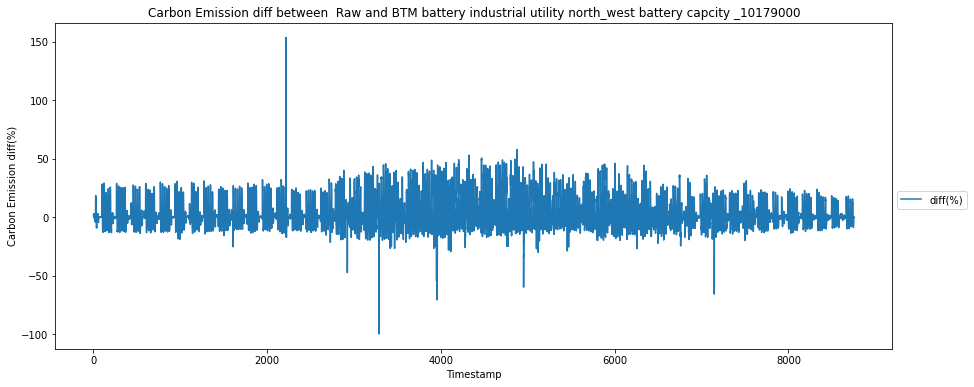

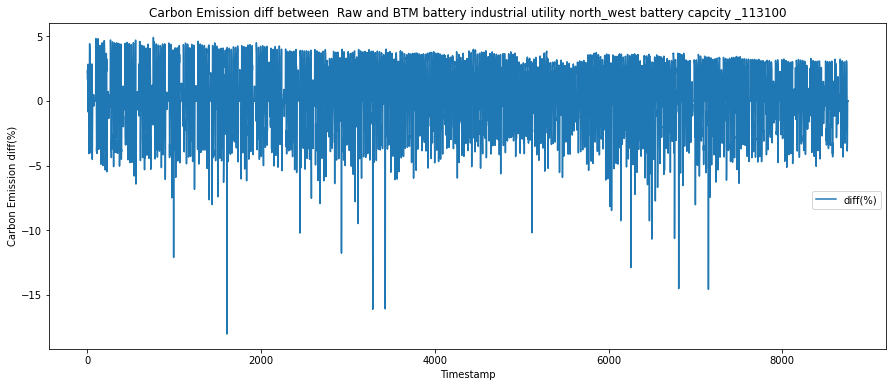

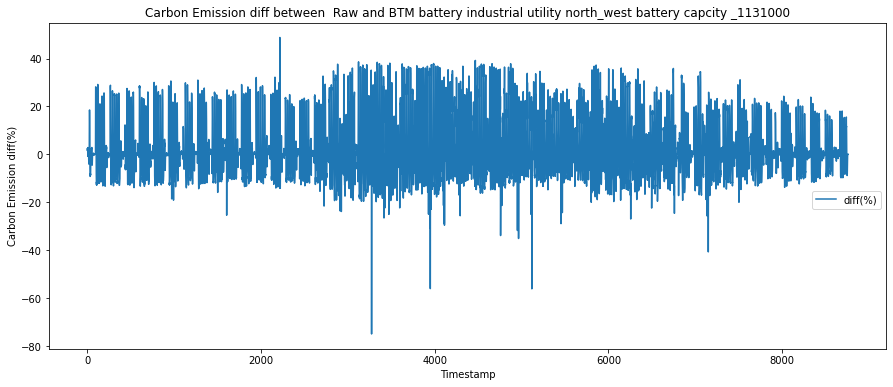

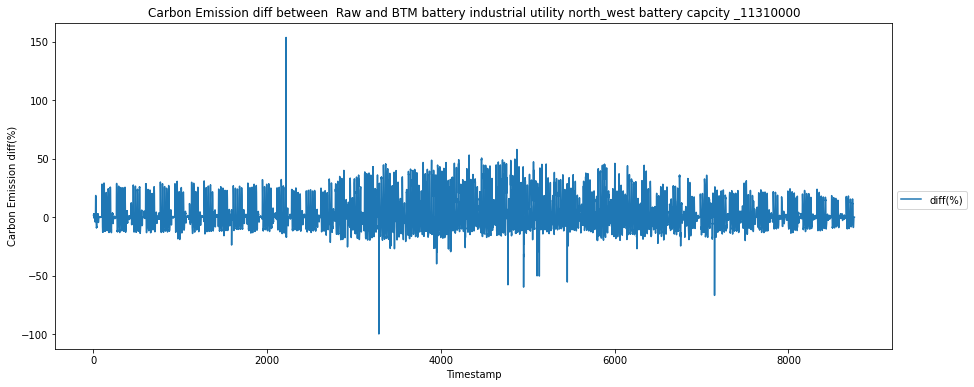

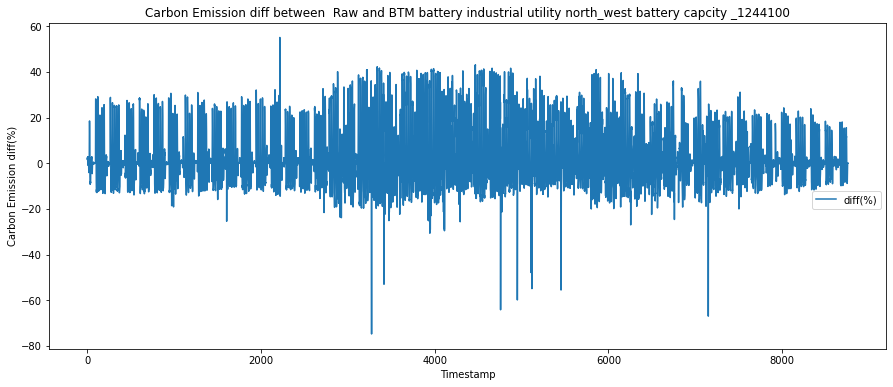

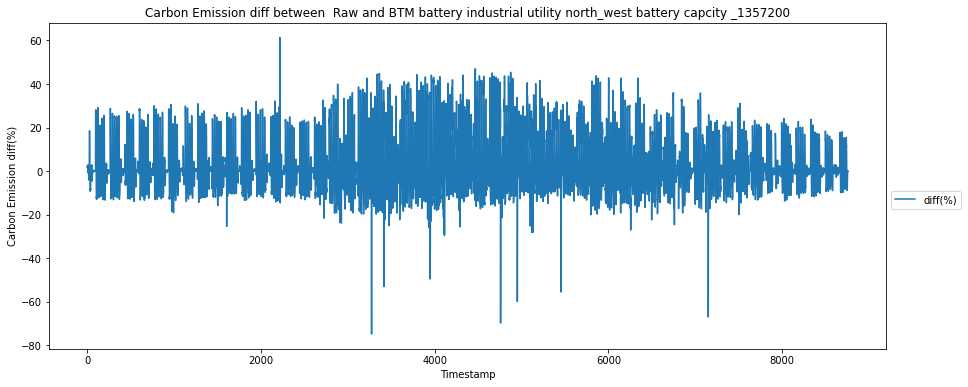

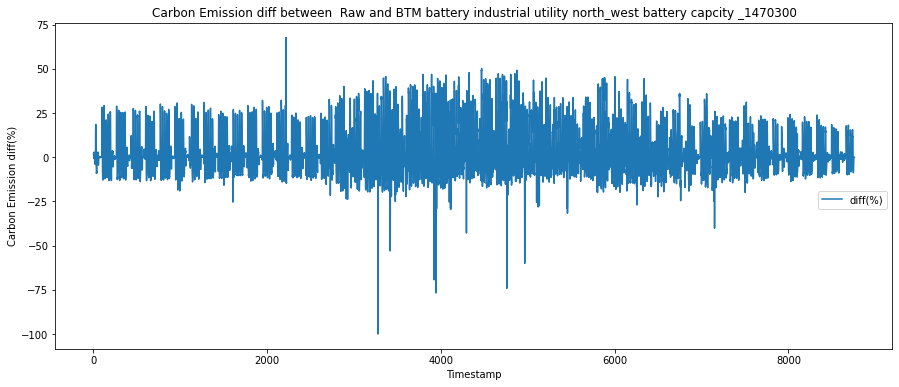

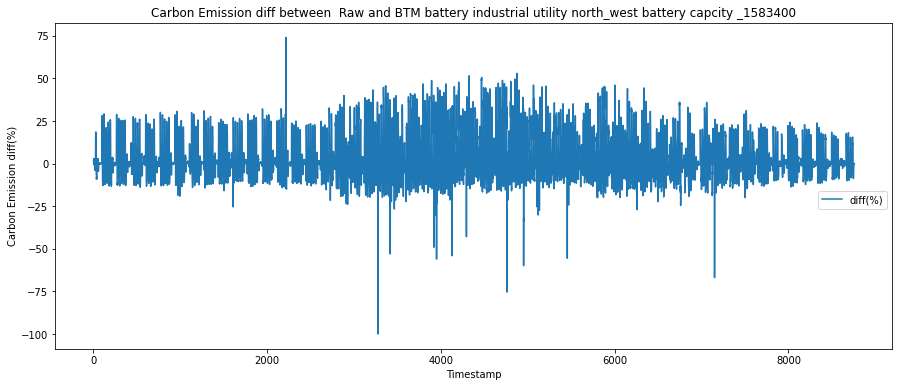

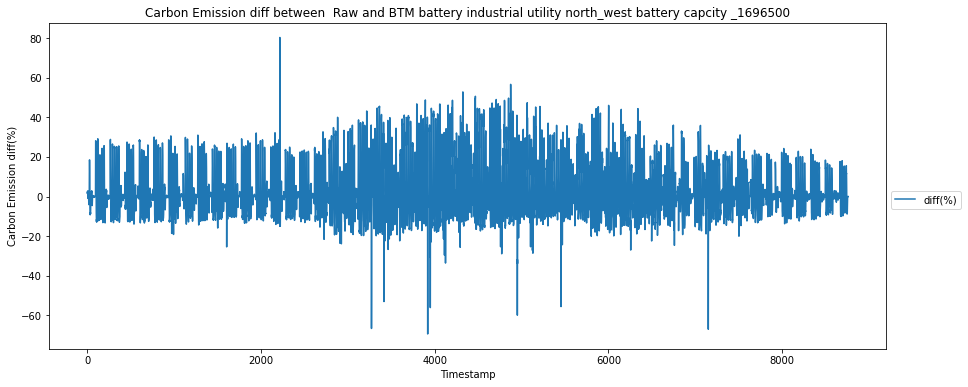

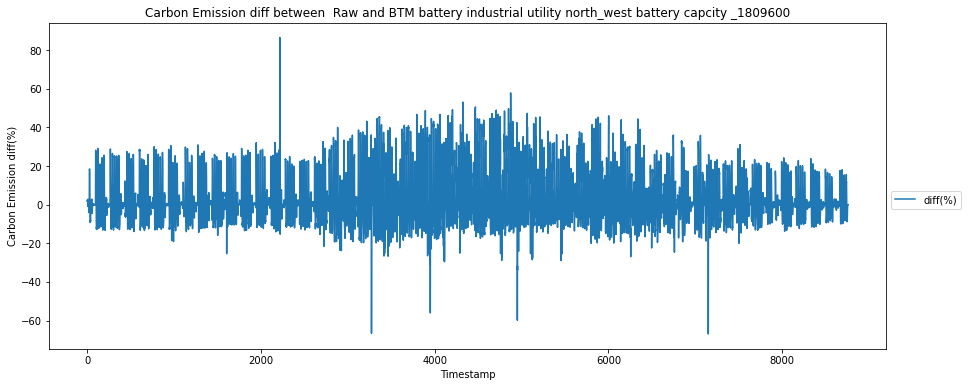

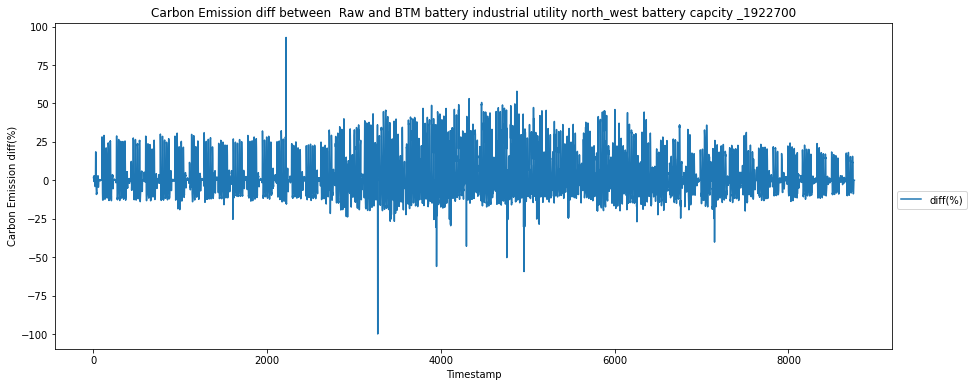

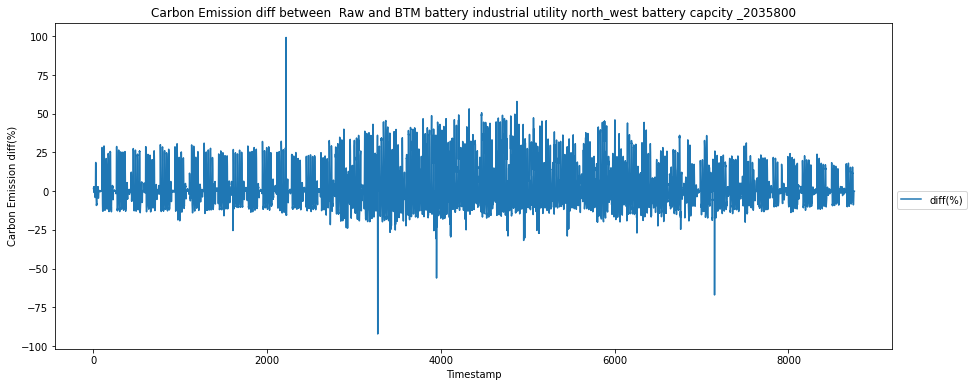

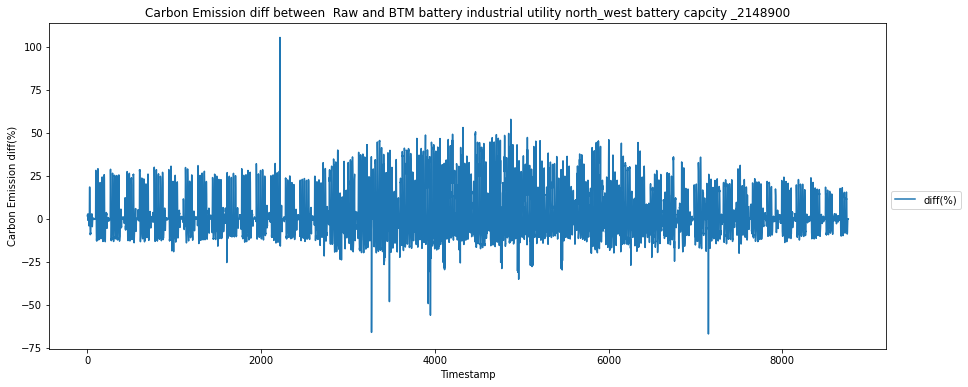

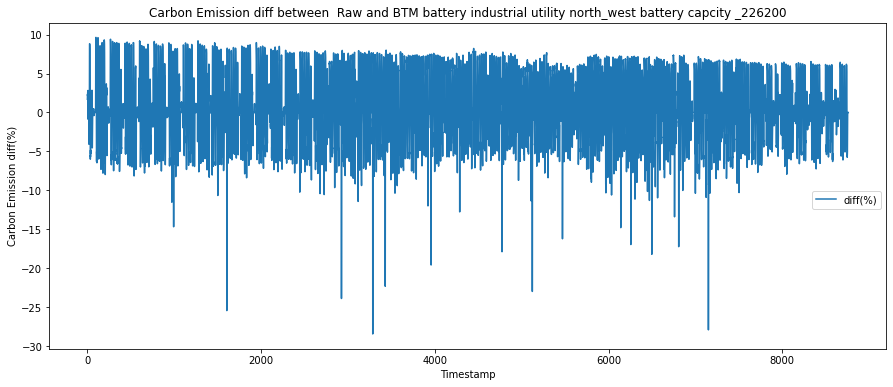

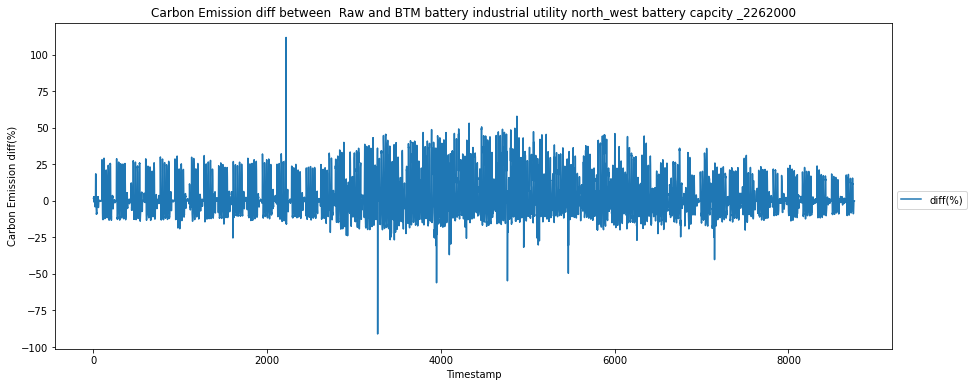

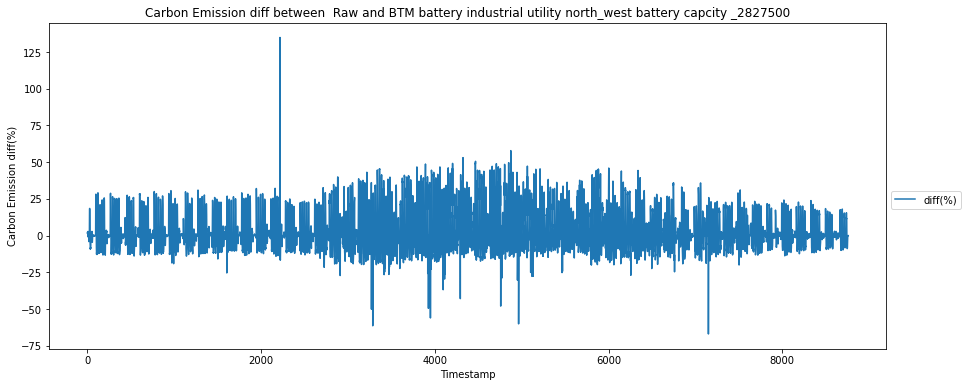

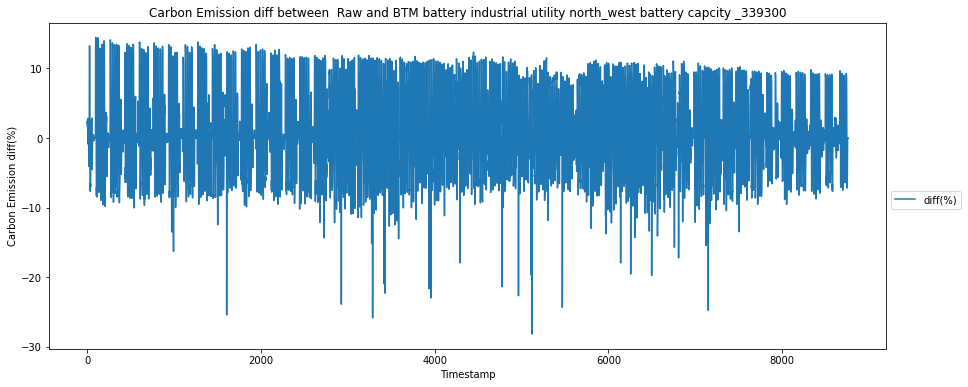

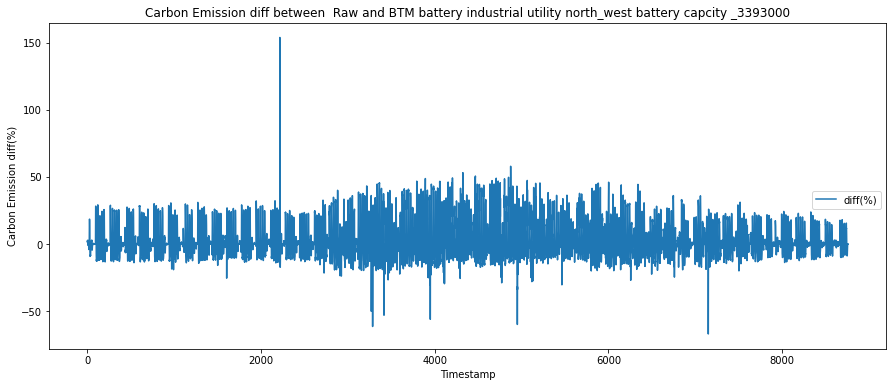

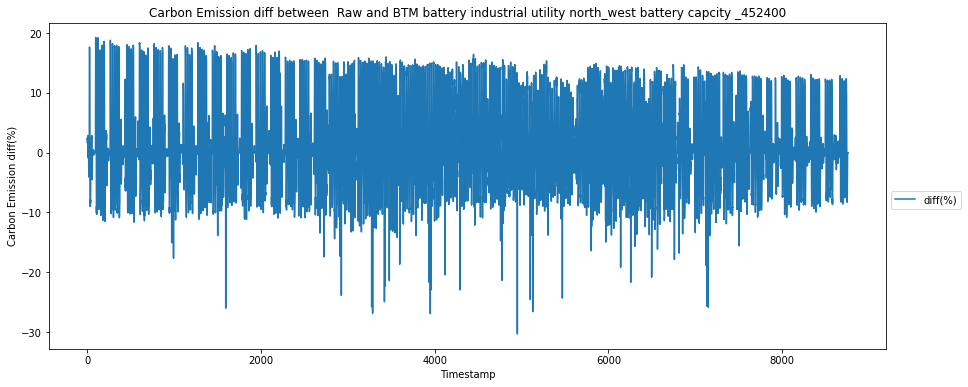

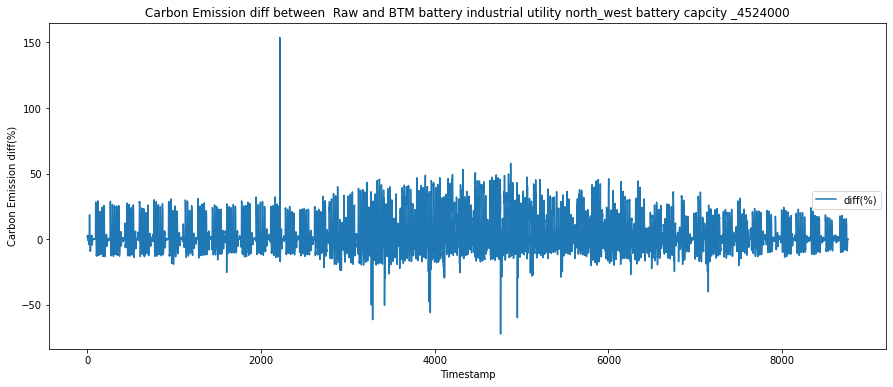

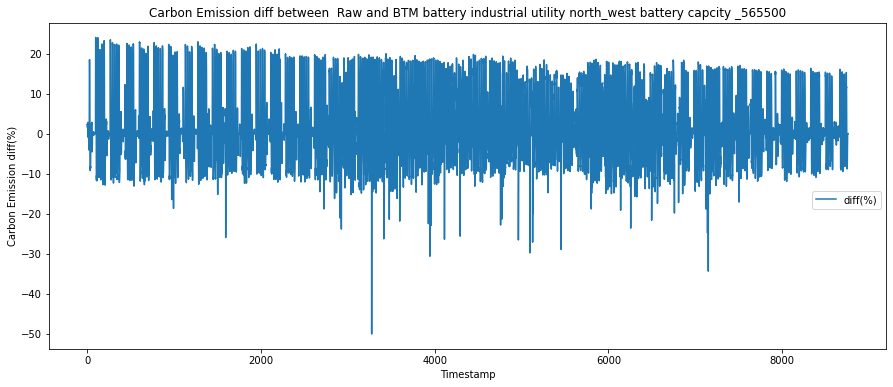

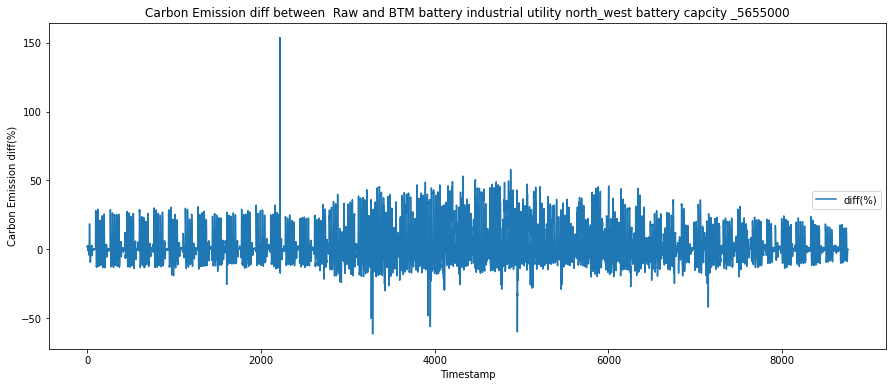

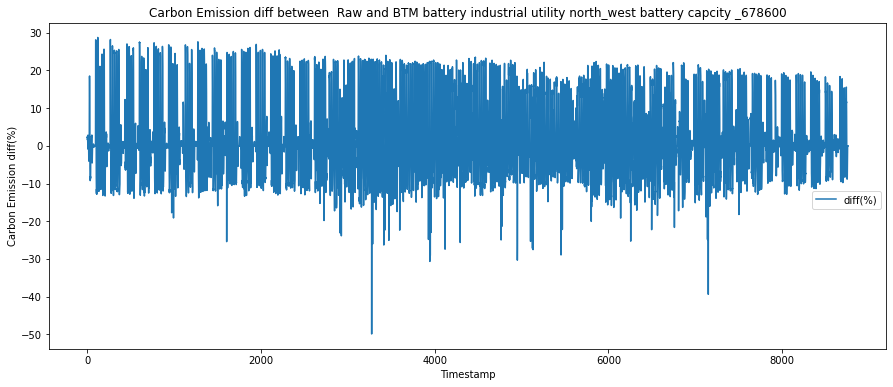

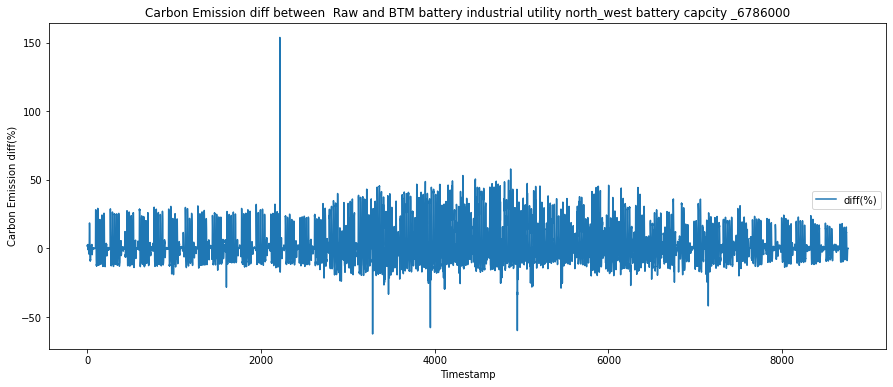

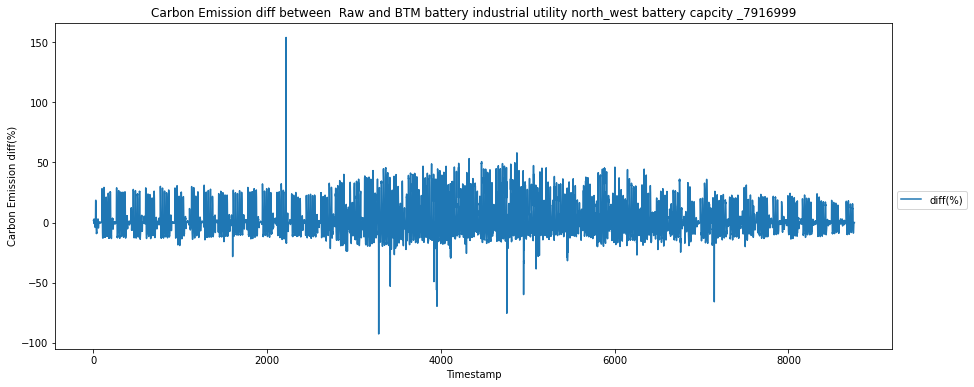

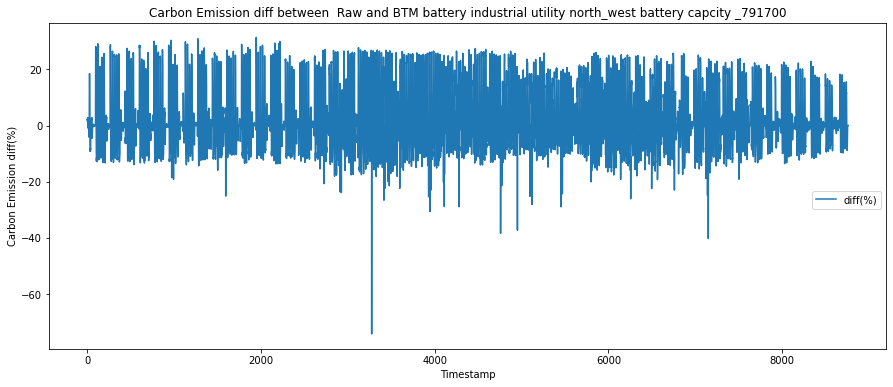

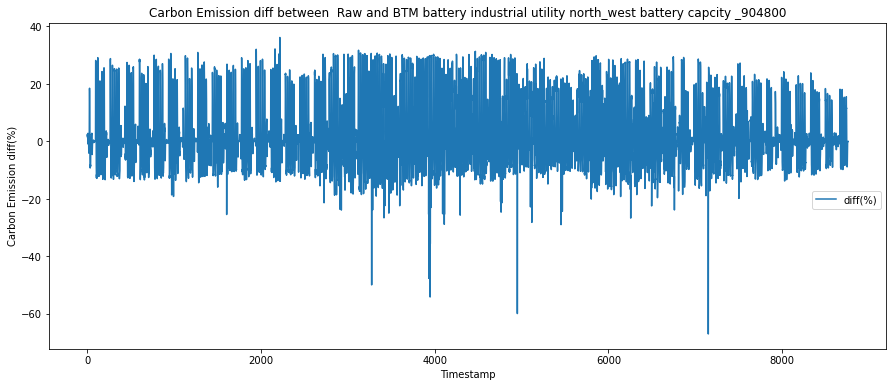

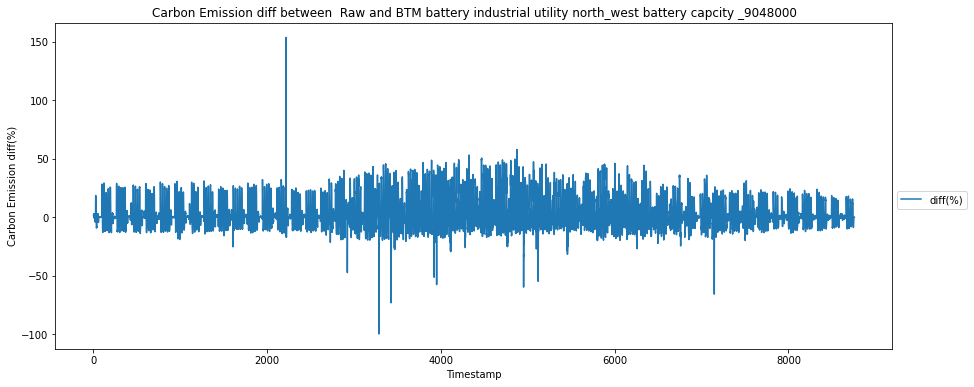

In [86]:
import re
p = re.compile('\_\d+')
industry = "indust1_seattle_pricing"
# industry = "indust1_hge_pricing"

name = "load_aft_batt_on_grid.txt_*_hwb"
filesnames = glob.glob('/content/drive/MyDrive/power/dataset/'+industry+'/'+name)
filesnames.sort()

dfbatterycarbon = pd.DataFrame()
dfbatterycarbonfuel = pd.DataFrame()

for a in filesnames:
    dfbattery0 = pd.read_csv( a,header=None)
    dfbattery_hourly = df_calculate_btmcarbon(dfbattery0)

    furlpercent_obj = Fuelmix(region)
    dfbattery_hourly_fuelmix_btm = furlpercent_obj.calculate_fuelmixbypercent(dfbattery_hourly)

    carbonemissio_pbj = Carbon()
    dfbattery_hourly_fuelmix_carbon_btm = carbonemissio_pbj.calculate_carbonemission(dfbattery_hourly_fuelmix_btm)

    # graph
    # fig, ax = plt.subplots()
    # fig.set_size_inches(15, 6)
    # dfbattery_hourly_fuelmix_carbon_btm.plot( 
    #     x = "TIME",
    #     y = np.array(column_list_carbon),
    #     title = "Carbon Emission from Raw industrial utility "+ region + " battery capcity "+ p.findall(a)[0] ,
    #     ax=ax) 
    # ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
    # ax.set_xlabel("Timestamp")
    # ax.set_ylabel("Carbon Emission (kgCO2eq)")


    # diff carbon total
    diffcarbon = pd.DataFrame()
    diffcarbon["Timestamp"] = dfindus_hourly_fuelmix_carbon["Timestamp"]
    diffcarbon["diff(kgeCO2)"] = dfbattery_hourly_fuelmix_carbon_btm["carbon_total(kgeCO2)"] - dfindus_hourly_fuelmix_carbon["carbon_total(kgeCO2)"]
    diffcarbon["diff(%)"] = diffcarbon["diff(kgeCO2)"] *100 / dfindus_hourly_fuelmix_carbon["carbon_total(kgeCO2)"]
    # graph
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    diffcarbon.plot( 
        # x = "TIME",
        y = ["diff(%)"],
        title = "Carbon Emission diff between  Raw and BTM battery industrial utility "+ region + " battery capcity "+ p.findall(a)[0] ,
        ax=ax) 
    ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Carbon Emission diff(%)")

    dfbatterycarbon["Timestamp"] = dfindus_hourly_fuelmix_carbon["Timestamp"]
    dfbatterycarbon[p.findall(a)[0]] = diffcarbonpercent

    # diff carbon by fuel
    # df_diffcarbonfuel = dfindus_hourly_fuelmix_carbon[np.array(column_list_carbon)] - dfbattery_hourly_fuelmix_carbon_btm[np.array(column_list_carbon)] 
    # dfbatterycarbonfuel[p.findall(a)[0]] =df_diffcarbonfuel

dfbatterycarbon.head()

In [81]:
dfbatterycarbon.tail()

,Timestamp,_1017900,_10179000,_113100,_1131000,_11310000,_1244100,_1357200,_1470300,_1583400,_1696500,_1809600,_1922700,_2035800,_2148900,_226200,_2262000,_2827500,_339300,_3393000,_452400,_4524000,_565500,_5655000,_678600,_6786000,_7916999,_791700,_904800,_9048000
8755,2009-12-31 19:00:00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8756,2009-12-31 20:00:00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8757,2009-12-31 21:00:00,0.0,0.0,-1.012522e-13,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,2.025043e-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8758,2009-12-31 22:00:00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,2009-12-31 23:00:00,0.0,0.0,0.000000e+00,0.0,1.211782e-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.615710e-13,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Difference in carbon emisson from raw and BTM storage

In [73]:
# dfindus_hourly["diff(kgeCO2)"] = carbondiff 
# dfindus_hourly["diff(%)"] = carbondiff *100 / dfindus_hourly["carbon_total(kgeCO2)"]

# dfindus_hourly.head()

In [82]:
dfbatterycarbon_monthly = dfbatterycarbon.resample('M',on='Timestamp').agg({
                                        'diff(%)':'mean', 
                                        'diff(kgeCO2)':'sum'})

SpecificationError: ignored

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

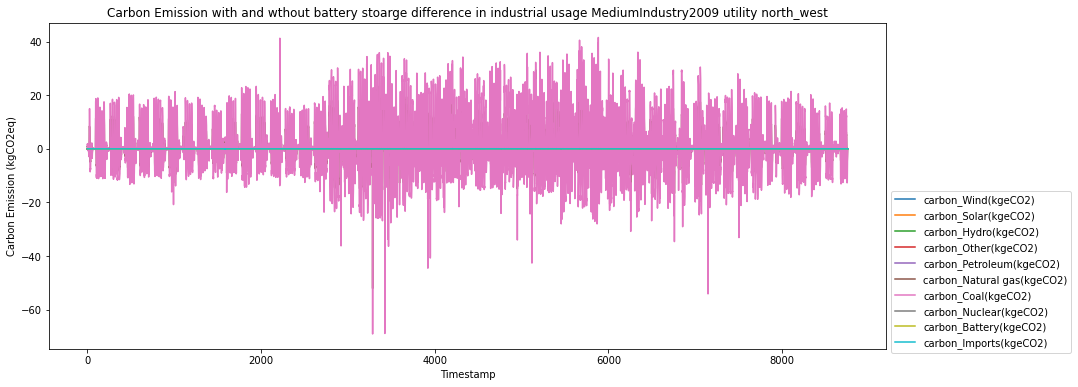

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
df_carbondiff.plot( 
    y = np.array(column_list_carbon),
    title = "Carbon Emission with and wthout battery stoarge difference in industrial usage "+ Region +" utility "+ region ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

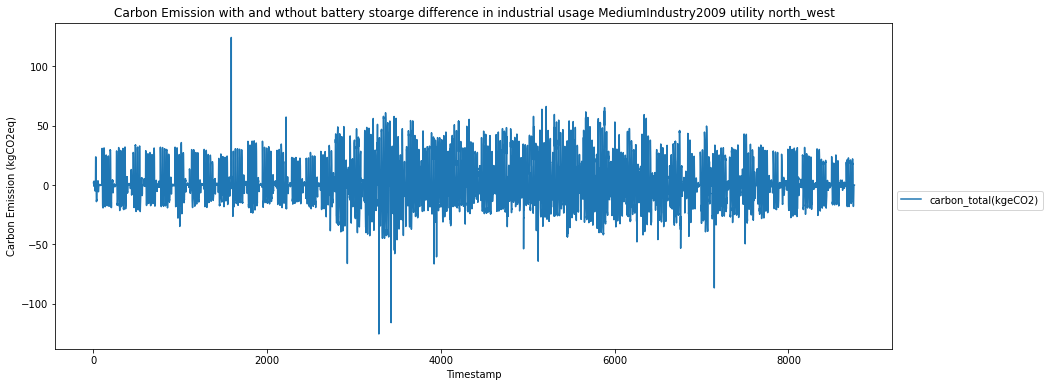

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
carbondiff.plot( 
    y = ["carbon_total(kgeCO2)"],
    title = "Carbon Emission with and wthout battery stoarge difference in industrial usage "+ Region +" utility "+ region ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")
# ax.set_xticklabels(months_list)

Text(0, 0.5, 'Carbon Emission diff(%)')

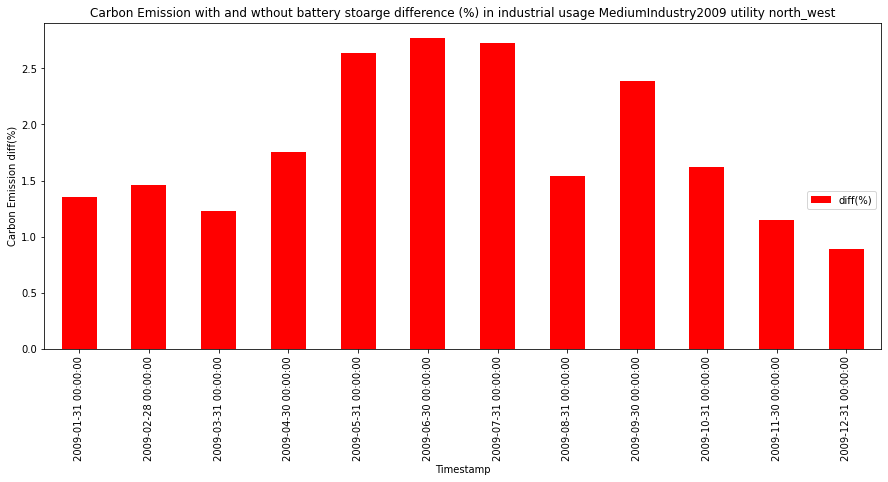

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfindus_monthly.plot.bar( 
    # x="Timestamp",
    y=["diff(%)"],
    title = "Carbon Emission with and wthout battery stoarge difference (%) in industrial usage "+ Region +" utility "+ region ,
    color="red",
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission diff(%)")
# ax.set_xticklabels(months_list)

## To csv

In [68]:
df_carbondiff.to_csv(region+"_carbondiff.csv",index=True, header=True)